# ANA-1639 "... demonstrate requirements for valuation of FxOptions"

## Initialisation: API

- Load python modules
- Authentificate
- Get functions to call LUSID API

In [1]:
import os, logging, pytz, re
logging.basicConfig(format='%(asctime)s %(message)s',level=logging.DEBUG)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

import lusid
import lusid.models as lm
import lusid.api as la
from lusid.utilities import ApiClientFactory

api_factory = ApiClientFactory(
    api_secrets_filename = os.getenv("FBN_SECRETS_PATH")
)

portfolio_api = api_factory.build(lusid.api.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
complex_market_data_api = api_factory.build(lusid.api.ComplexMarketDataApi)
aggregation_api = api_factory.build(lusid.api.AggregationApi)
events_api = api_factory.build(lusid.api.InstrumentEventsApi)

logging.debug('LUSID Environment Initialised')
logging.debug(f'LUSID API Version {api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version}')

2023-01-30 15:25:06,446 matplotlib data path: /usr/local/lib/python3.10/site-packages/matplotlib/mpl-data
2023-01-30 15:25:06,456 CONFIGDIR=/Users/zvyagin/.matplotlib
2023-01-30 15:25:06,459 interactive is False
2023-01-30 15:25:06,459 platform is darwin
2023-01-30 15:25:06,592 CACHEDIR=/Users/zvyagin/.matplotlib
2023-01-30 15:25:06,600 Using fontManager instance from /Users/zvyagin/.matplotlib/fontlist-v330.json
2023-01-30 15:25:10,633 LUSID Environment Initialised
2023-01-30 15:25:11,930 LUSID API Version 0.6.10721.0


### The compuation logic
There are several scenarious for which we perform some compuations.

In [2]:
scenarios = [
    'European FxOption priced by Discounting model',
    'European FxOption priced by BlackScholes model',
    'American FxOption priced by BjerksundStensland1993 model',
    'European digital FxOption priced by BlackScholesDigital model',
]

def run (scenario=''):
    '''Scenarios:
        - European vanilla option priced by BlackScholes model
    '''
    # A placeholder for common variables
    context = create_context()
    context.scenario = scenario if scenario else scenarios[0]
    print('scenario: ',context.scenario)

    create_portfolio                            (context)
    create_FxOption                             (context)
    add_the_newly_created_FxOption_to_portfolio (context)
    get_quotes                                  (context)
    add_domestic_and_foreign_curves             (context)
    add_Fx_data                                 (context)
    add_FxVolatilitySurface_data                (context)
    create_valuation_recipe                     (context)
    run_valuation                               (context)
    get_events                                  (context)
    show_cashflows                              (context)
    get_tradetickets                            (context)

    return context

In [3]:
def get_models (scenario):
    return [
        model for model in
            ('Discounting','BlackScholes','BlackScholesDigital','BjerksundStensland1993')
        if re.search(f'({model})\s',scenario)
    ]

In [4]:
class Context:
    def __init__ (self):
        self.prefix             = 'FxOptionOverview1'

        self.portfolio_birthday = datetime(2022, 11, 3, tzinfo=pytz.utc)
        self.portfolio_code     = f'{self.prefix}-portfolio-code'
        self.portfolio_scope    = f'{self.prefix}-portfolio-scope'
        
        self.instruments_scope  = f'{self.prefix}-instruments-scope'
        
        self.market_data_scope  = f'{self.prefix}-market-scope'
        self.market_supplier    = 'Lusid'
        
        self.recipe_code        = f'{self.prefix}-recipe-code'
        self.recipe_scope       = f'{self.prefix}-recipe-scope'

        self.dom_ccy            = 'EUR'
        self.fgn_ccy            = 'USD'
        
        self.fxOption_name       = 'FxOption MyName'
        self.fxOption_id         = 'FxOption MyId'
        
        self.deal_id             = 'Deal MyId'

        self.trade_date          = self.portfolio_birthday
        self.valuation_date      = self.portfolio_birthday
        
        self.tables              = {}
        
    def Cleanup (self):
        try:
            portfolio_api.delete_portfolio (
                self.portfolio_scope,
                self.portfolio_code
            )
        except lusid.ApiException as e:
            if not e.reason=='Not Found':
                logging.error(e)
        

In [5]:
def create_context ():
    context = Context()
    context . Cleanup()
    return context

In [6]:
def create_portfolio (context):
    transaction_portfolios_api.create_portfolio(
    context.portfolio_scope,
    create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=context.portfolio_code,
            code=context.portfolio_code,
            base_currency=context.dom_ccy,
            created=context.portfolio_birthday,
            sub_holding_keys = [],
            instrument_scopes=[context.instruments_scope]
        ),
    )

In [7]:
# Define a function to upsert instrument
def upsert_instrument_to_lusid(scope, instrument, name, identifier, identifier_type):
    return instruments_api.upsert_instruments(
        request_body={
            identifier: lm.InstrumentDefinition(
                name=name,
                identifiers={
                    identifier_type: lm.InstrumentIdValue(value=identifier)
                },
                definition=instrument,
            )
        },
        scope = scope
    )

In [8]:
def create_FxOption (context):
    is_payoff_digital = context.scenario.find('digital') >= 0
    exercise_type = None
    for name in ['American','European']:
        if context.scenario.find(name) >=0:
            exercise_type = name

    barriers = []
    if context.scenario.find('single-barrier')>=0:
        barriers.append(lm.barrier.Barrier('Up',0.91,'European','Knockin'))
    if context.scenario.find('double-barrier')>=0:
        barriers.append(lm.barrier.Barrier('Up',0.91,'European','Knockin'))
        barriers.append(lm.barrier.Barrier('Up',0.99,'European','Knockout'))
        
    context.strike = 0.9
    
    if is_payoff_digital:
        is_delivery_not_cash = False
    else:
        if context.scenario.find('CashDelivery')>=0:
            is_delivery_not_cash = False
        elif context.scenario.find('PhysicalDelivery')>=0:
            is_delivery_not_cash = True
        else:
            # Default
            is_delivery_not_cash = False
    
    start_date = context.portfolio_birthday
    context.fxOption1 = lm.FxOption(
        strike = context.strike,
        dom_ccy = context.dom_ccy,
        fgn_ccy = context.fgn_ccy,
        start_date = start_date,
        option_maturity_date = start_date+timedelta(days=90),
        option_settlement_date = start_date+timedelta(days=90)+timedelta(2),
        is_call_not_put = True,
        is_delivery_not_cash = is_delivery_not_cash,
        is_payoff_digital = is_payoff_digital,
        instrument_type = 'FxOption',
        dom_amount = 100,
        exercise_type = exercise_type,
        barriers=barriers
    )

    upsert_instrument_to_lusid(
        context.instruments_scope, context.fxOption1, context.fxOption_name, context.fxOption_id, 'ClientInternal'
    )

In [9]:
# from collections import namedtuple
# def get_default_dates (context):
#     Dates = namedtuple('Dates',['effective_at','window_start','window_end'])

#     start_date = context.portfolio_birthday
#     return Dates(
#         effective_at=start_date+timedelta(days=10),
#         window_start=start_date,
#         window_end=start_date+timedelta(days=1000)
#     )


In [10]:
def add_the_newly_created_FxOption_to_portfolio (context):
    premium = 0.02
    units = 1000000

    opt_txn = lm.TransactionRequest(
        transaction_id = context.deal_id + "." + context.fxOption_name,
        type="Buy",
        instrument_identifiers={"Instrument/default/ClientInternal": context.fxOption_id},
        transaction_date=context.trade_date,
        settlement_date=context.trade_date + timedelta(days = 2),
        units=units,
        transaction_price=lm.TransactionPrice(price=premium,type="Price"),
        total_consideration=lm.CurrencyAndAmount(amount=premium*units,currency=context.dom_ccy),
        exchange_rate=1,
        transaction_currency=context.dom_ccy,
    )

    response = transaction_portfolios_api.upsert_transactions(
        scope=context.portfolio_scope,
        code=context.portfolio_code,
        transaction_request=[opt_txn]
    )

    logging.debug(f"Transaction successfully updated at time: {response.version.as_at_date}")

In [11]:
def add_domestic_and_foreign_curves (context):

    # Set up the OIS curves loader function
    def upsert_discount_factors(effective_at, market_asset, dates, dfs):

        complex_market_data = lm.DiscountFactorCurveData(
            base_date=effective_at,
            dates=dates,
            discount_factors = dfs,
            market_data_type="DiscountFactorCurveData"
        )

        # create a unique identifier for our OIS yield curves
        complex_id = lm.ComplexMarketDataId(
            provider=context.market_supplier,
            price_source = context.market_supplier,
            effective_at=effective_at,
            market_asset=market_asset,
        )

        upsert_request = lm.UpsertComplexMarketDataRequest(
            market_data_id=complex_id, market_data=complex_market_data
        )


        response = complex_market_data_api.upsert_complex_market_data(
            scope=context.market_data_scope, request_body={market_asset: upsert_request}
        )

        if response.failed:
            raise Exception(f"Failed to upload yield curve {response.failed}")

        logging.debug(f"{market_asset} yield curve uploaded into scope={context.market_data_scope}")

        return complex_id

    
    context.curves = {}
    for ccy in ['EUR','USD']:
        base_date = context.trade_date
        dates = []
        dfs = []
        for index, row in context.df_market_data.iterrows():
            dates.append(base_date + timedelta(days=row['Days']))
            dfs.append(row[f'{ccy}df'])
        context.curves[ccy] = upsert_discount_factors(base_date, f'{ccy}/{ccy}OIS', dates, dfs)


In [12]:
def get_quotes (context):

    # Read FX market data - showing first 10 terms
    context.df_market_data = pd.read_csv("data/EURUSD-MarketData.csv")
    context.df_market_data["Days"]= context.df_market_data["Days"].astype(int)
    context.df_market_data = context.df_market_data.reset_index()
    context.df_market_data.head(10)

    
    # Read fx spot rates and make datetimes timezone aware
    context.quotes_df = pd.read_csv("data/eurusd_spot.csv")
    context.quotes_df["Date"] = pd.to_datetime(context.quotes_df["Date"], dayfirst=True)
    context.quotes_df["Date"] = context.quotes_df["Date"].apply(lambda x: x.replace(tzinfo=pytz.utc))
    # quotes_df.head()

In [13]:
def add_Fx_data (context):

    # Create quotes request
    instrument_quotes = {
                index: lm.UpsertQuoteRequest(
                quote_id=lm.QuoteId(
                    quote_series_id=lm.QuoteSeriesId(
                        provider=context.market_supplier,
                        instrument_id=row["Pair"],
                        instrument_id_type="CurrencyPair",
                        quote_type="Rate",
                        field="mid",
                    ),
                    effective_at=row["Date"],
                ),
                metric_value=lm.MetricValue(value=row["Rate"], unit=row["Pair"]),
            )
        for index, row in context.quotes_df.iterrows()
    }

    # Upsert quotes into LUSID
    response = quotes_api.upsert_quotes(
        scope = context.market_data_scope, request_body=instrument_quotes
    )

    if response.failed == {}:
        logging.debug(f"Quotes successfully loaded into LUSID. {len(response.values)} quotes loaded.")
    else:
        raise Exception(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

In [14]:
def upsert_fxoption_curve_instruments (context, data):
    identifier_type = "ClientInternal"

    for index, row in data.iterrows():

        option_expiry = context.trade_date + timedelta(days=row["Days"])

        # Create the Instrument
        option_definition = lm.FxOption(
            strike = row["Strike"],
            dom_ccy = context.dom_ccy,
            fgn_ccy = context.fgn_ccy,
            start_date = context.trade_date,
            option_maturity_date = option_expiry,
            option_settlement_date = option_expiry + timedelta(days=2),
            is_call_not_put = True,
            is_delivery_not_cash = False,
            is_payoff_digital = False,
            instrument_type = "FxOption",
            dom_amount = 1
        )

        option_name = "EUR/USD " + " FX Option " + option_expiry.strftime("%m/%d/%Y")
        option_identifier = (f"EURUSDVolCurve{index}:{row['Strike']}")

        context.curve_map.append({option_name : option_identifier})
        context.curve_instruments.append(option_definition)

        # Upsert the instrument
        upsert_response = upsert_instrument_to_lusid(context.market_data_scope, option_definition, option_name, option_identifier, identifier_type)
        context.curve_instruments_id.append(upsert_response.values[option_identifier].lusid_instrument_id)

def add_FxVolatilitySurface_data (context):

    if get_models(context.scenario) == ['Discounting']:
        logging.debug('Discounting model does not use volatility.')
        return
    
    context.curve_instruments = []
    context.curve_instruments_id = []
    context.curve_map = []

    for offset in ('25D','ATM','75D'):
        upsert_fxoption_curve_instruments (context, context.df_market_data[["Days", f"Strike{offset}"]].rename(columns={f"Strike{offset}" : "Strike"}))

    logging.debug(f"{len(context.curve_instruments)} instruments uploaded to create the vol curve")

    market_asset = f'{context.dom_ccy}/{context.fgn_ccy}/LN'

    market_data_id = lm.ComplexMarketDataId(
        provider=context.market_supplier,
        price_source=context.market_supplier,
        effective_at=context.valuation_date,
        market_asset=market_asset,
    )
    
    quotes = []
    
    for name in ['Vol25D','ATM','Vol75D']:
        for vol in context.df_market_data[name]:
            quotes.append(lm.MarketQuote(quote_type="LogNormalVol", value=vol))

    fx_vol_surface_data = lm.FxVolSurfaceData(
        base_date=context.trade_date,
        instruments=context.curve_instruments,
        quotes=quotes,
        market_data_type="FxVolSurfaceData"
    )  
    
    response = complex_market_data_api.upsert_complex_market_data(
        scope=context.market_data_scope,
        request_body={
            market_asset: lm.UpsertComplexMarketDataRequest(
                market_data_id=market_data_id, market_data=fx_vol_surface_data
            )
        },
    )
    
    if len(response.failed) == 0:
        print(f"Quote successfully loaded into LUSID. {len(response.values)} quotes loaded.")
    else:
        raise Exception(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")
        
    return market_data_id
    
def plot_FxVolSurface (context):
    logging.getLogger().setLevel(logging.INFO)
    Xs = []
    Ys = []
    Zs = []

    for index, row in context.df_market_data.iterrows():
        Xs.append(row["Strike25D"])
        Ys.append(row["Days"])
        Zs.append(row["Vol25D"])

    for index, row in context.df_market_data.iterrows():
        Xs.append(row["StrikeATM"])
        Ys.append(row["Days"])
        Zs.append(row["ATM"])

    for index, row in context.df_market_data.iterrows():
        Xs.append(row["Strike75D"])
        Ys.append(row["Days"])
        Zs.append(row["Vol75D"])

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('Strike', fontweight ='bold')
    ax.set_ylabel('Tenor', fontweight ='bold')
    ax.set_zlabel('Implied Vol', fontweight ='bold')
    surf = ax.plot_trisurf(Xs, Ys, Zs, linewidth=0.1)
    plt.yticks(context.df_market_data["Days"], context.df_market_data["Tenor"], rotation='vertical', color = '#4b6dd1')
    
    return plt.show()

In [15]:
def create_valuation_recipe (context):
    '''List of models: Discounting, BlackScholes, BlackScholesDigital, BjerksundStensland1993'''
        
    quote_interval = '1000D'

    # Populate recipe parameters
    configuration_recipe = lm.ConfigurationRecipe(
        scope=context.recipe_scope,
        code=context.recipe_code,
        market=lm.MarketContext(
            market_rules=[
                lm.MarketDataKeyRule(
                    key="Fx.CurrencyPair.*",
                    supplier=context.market_supplier,
                    data_scope=context.market_data_scope,
                    quote_type="Rate",
                    field="mid",
                    quote_interval=quote_interval
                ),
                lm.MarketDataKeyRule(
                    key="FxVol.*.*.*",
                    supplier=context.market_supplier,
                    data_scope=context.market_data_scope,
                    price_source=context.market_supplier,
                    quote_type="Price",
                    field="mid",
                    quote_interval=quote_interval
                ),
                lm.MarketDataKeyRule(
                    key="Rates.*.*",
                    supplier=context.market_supplier,
                    data_scope=context.market_data_scope,
                    price_source=context.market_supplier,
                    quote_type="Price",
                    field="mid",
                    quote_interval=quote_interval
                ),
            ],
            options=lm.MarketOptions(
                default_scope = context.market_data_scope,
                attempt_to_infer_missing_fx=True
            ),
        ),
        pricing=lm.PricingContext(
            model_rules=[
                lm.VendorModelRule(
                    supplier=context.market_supplier,
                    model_name=model_name,
                    instrument_type="FxOption",
                    parameters="{}",
                )
                for model_name in get_models(context.scenario)
            ],
            options = lm.PricingOptions(
                allow_partially_successful_evaluation = False
            )
        ),
    )

    response = configuration_recipe_api.upsert_configuration_recipe(
        upsert_recipe_request=lm.UpsertRecipeRequest(
            configuration_recipe=configuration_recipe
        )
    )

    logging.debug(f"Configuration recipe loaded into LUSID at time {response.value}.")

In [16]:
def run_valuation (context):

    metrics = [
        lm.AggregateSpec("Instrument/default/Name", "Value"),
        lm.AggregateSpec("Holding/Units", "Value"),
        lm.AggregateSpec("Valuation/PV/Amount", "Value"),
        lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
        lm.AggregateSpec("Valuation/Delta", "Value"),
        lm.AggregateSpec("Valuation/Risk/SpotDelta", "Value"),
        lm.AggregateSpec("Valuation/Exposure", "Value"),
    ]

    group_by =[]

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=context.recipe_scope, code=context.recipe_code),
        metrics=metrics,
        group_by=group_by,
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=context.portfolio_scope, code=context.portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(effective_at=context.valuation_date),
    )

    context.valuation_response = aggregation_api.get_valuation(valuation_request=valuation_request)
    
    context.tables['valuation'] = pd.DataFrame(context.valuation_response.data)
    context.tables['valuation'].rename(
        columns={
            "Instrument/default/Name": "InstrumentName",
            "Instrument/default/ClientInternal": "ClientInternal",
            "Valuation/PvInPortfolioCcy": "Market Value",
            "Valuation/Diagnostics/FxForwardRate": "Forward Rate (Interpolated)",
            "Quotes/FxRate/DomFgn": "FX Spot Rate",
            "Valuation/PnL/Tm1/Pfolio": "PnL (1-day)",
        },
        inplace=True,
    )

In [17]:
def get_events(context):
    events_request = lm.QueryInstrumentEventsRequest(
        effective_at=context.portfolio_birthday,
        window_start=context.portfolio_birthday,
        window_end=context.fxOption1.option_settlement_date,
        portfolio_entity_ids=[lm.PortfolioEntityId(scope=context.portfolio_scope, code=context.portfolio_code)],
        recipe_id=lm.ResourceId(scope=context.recipe_scope, code=context.recipe_code)
    )
    context.exercise_events = events_api.query_instrument_events(query_instrument_events_request=events_request)
    context.tables['exercise_events'] = lusid_response_to_data_frame(context.exercise_events)

In [18]:
def get_tradetickets (context):
    start_date = context.portfolio_birthday
    events_request = lm.QueryTradeTicketsRequest(
        effective_at=start_date+timedelta(days=10),
        window_start=start_date,
        window_end=start_date+timedelta(days=1000),
        portfolio_entity_ids=[lm.PortfolioEntityId(scope=context.portfolio_scope, code=context.portfolio_code)],
        recipe_id=lm.ResourceId(scope=context.recipe_scope, code=context.recipe_code)
    )
    context.trade_tickets = events_api.query_trade_tickets(query_trade_tickets_request=events_request)
    context.tables['trade_tickets'] = lusid_response_to_data_frame(context.trade_tickets)

In [19]:
def show_cashflows(context):
    logging.debug('show_cashflows')
    pass

# Results for different FxOption types

In [20]:
results = {}

## European FxOption priced by Discounting model

In [21]:
scenario = 'European FxOption priced by Discounting model'
result = run(scenario)
results[scenario] = result

scenario:  European FxOption priced by Discounting model


2023-01-30 15:25:14,072 Transaction successfully updated at time: 2023-01-30 15:25:13.917129+00:00
2023-01-30 15:25:14,284 EUR/EUROIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:14,477 USD/USDOIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:14,866 Quotes successfully loaded into LUSID. 223 quotes loaded.
2023-01-30 15:25:14,867 Discounting model does not use volatility.
2023-01-30 15:25:15,065 Configuration recipe loaded into LUSID at time 2023-01-30 15:25:14.961879+00:00.
2023-01-30 15:25:16,126 show_cashflows


In [22]:
result.fxOption1

{'barriers': [],
 'dom_amount': 100,
 'dom_ccy': 'EUR',
 'exercise_type': 'European',
 'fgn_amount': None,
 'fgn_ccy': 'USD',
 'instrument_type': 'FxOption',
 'is_call_not_put': True,
 'is_delivery_not_cash': False,
 'is_payoff_digital': False,
 'option_maturity_date': datetime.datetime(2023, 2, 1, 0, 0, tzinfo=<UTC>),
 'option_settlement_date': datetime.datetime(2023, 2, 3, 0, 0, tzinfo=<UTC>),
 'payout_style': None,
 'premium': None,
 'start_date': datetime.datetime(2022, 11, 3, 0, 0, tzinfo=<UTC>),
 'strike': 0.9,
 'touches': None}

In [23]:
result.tables['valuation']

,Valuation/PV/Amount,InstrumentName,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta,Valuation/Exposure
0,2.251193e+07,FxOption MyName,1000000.0,2.251193e+07,0.859534,0.009949,11530.948255
1,-2.000000e+04,EUR,-20000.0,-2.000000e+04,NaN,NaN,-20000.000000


In [24]:
result.tables['exercise_events']

,instrument_event_id,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_identifiers.Instrument/default/Currency,lusid_instrument_id,instrument_scope,description,instrument_event.anchor_date,instrument_event.instrument_event_type,properties.0.key,properties.0.value.label_value,instrument_event.reset_type,instrument_event.fixing_source,instrument_event.event_status,instrument_event.fixing_date,instrument_event.instrument.start_date,instrument_event.instrument.dom_ccy,instrument_event.instrument.principal,instrument_event.instrument.instrument_type,instrument_event.event_window_end
0,LUID_000049LE-OpenEvent-20221103-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Open...,2022-11-03 00:00:00+00:00,OpenEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT
1,LUID_000049LE-Reset-20230201-CurrencyPair-EURU...,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,NaT,ResetEvent,Instrument/default/EventStatus,Unknown,CurrencyPair,EURUSD,Unknown,2023-02-01 00:00:00+00:00,NaT,NaN,NaN,NaN,NaT
2,LUID_000049LE-Exercise-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,2023-02-01 00:00:00+00:00,ExerciseEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,Unknown,NaT,2023-02-03 00:00:00+00:00,EUR,1.0,CashPerpetual,2023-02-01 00:00:00+00:00
3,LUID_000049LE-CloseEvent-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Clos...,2023-02-01 00:00:00+00:00,CloseEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT


## European FxOption priced by BlackScholes model CashDelivery

In [25]:
scenario = 'European FxOption priced by BlackScholes model CashDelivery'
result = run(scenario)
results[scenario] = result

scenario:  European FxOption priced by BlackScholes model CashDelivery


2023-01-30 15:25:18,033 Transaction successfully updated at time: 2023-01-30 15:25:17.924472+00:00
2023-01-30 15:25:18,287 EUR/EUROIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:18,516 USD/USDOIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:18,941 Quotes successfully loaded into LUSID. 223 quotes loaded.
2023-01-30 15:25:22,832 30 instruments uploaded to create the vol curve


Quote successfully loaded into LUSID. 1 quotes loaded.


2023-01-30 15:25:23,330 Configuration recipe loaded into LUSID at time 2023-01-30 15:25:23.220967+00:00.
2023-01-30 15:25:24,198 show_cashflows


In [26]:
result.fxOption1

{'barriers': [],
 'dom_amount': 100,
 'dom_ccy': 'EUR',
 'exercise_type': 'European',
 'fgn_amount': None,
 'fgn_ccy': 'USD',
 'instrument_type': 'FxOption',
 'is_call_not_put': True,
 'is_delivery_not_cash': False,
 'is_payoff_digital': False,
 'option_maturity_date': datetime.datetime(2023, 2, 1, 0, 0, tzinfo=<UTC>),
 'option_settlement_date': datetime.datetime(2023, 2, 3, 0, 0, tzinfo=<UTC>),
 'payout_style': None,
 'premium': None,
 'start_date': datetime.datetime(2022, 11, 3, 0, 0, tzinfo=<UTC>),
 'strike': 0.9,
 'touches': None}

In [27]:
result.tables['valuation']

,Valuation/PV/Amount,InstrumentName,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta,Valuation/Exposure
0,2.251194e+07,FxOption MyName,1000000.0,2.251194e+07,0.996191,0.011531,13364.244786
1,-2.000000e+04,EUR,-20000.0,-2.000000e+04,NaN,NaN,-20000.000000


In [28]:
result.tables['exercise_events']

,instrument_event_id,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_identifiers.Instrument/default/Currency,lusid_instrument_id,instrument_scope,description,instrument_event.anchor_date,instrument_event.instrument_event_type,properties.0.key,properties.0.value.label_value,instrument_event.reset_type,instrument_event.fixing_source,instrument_event.event_status,instrument_event.fixing_date,instrument_event.instrument.start_date,instrument_event.instrument.dom_ccy,instrument_event.instrument.principal,instrument_event.instrument.instrument_type,instrument_event.event_window_end
0,LUID_000049LE-OpenEvent-20221103-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Open...,2022-11-03 00:00:00+00:00,OpenEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT
1,LUID_000049LE-Reset-20230201-CurrencyPair-EURU...,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,NaT,ResetEvent,Instrument/default/EventStatus,Unknown,CurrencyPair,EURUSD,Unknown,2023-02-01 00:00:00+00:00,NaT,NaN,NaN,NaN,NaT
2,LUID_000049LE-Exercise-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,2023-02-01 00:00:00+00:00,ExerciseEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,Unknown,NaT,2023-02-03 00:00:00+00:00,EUR,1.0,CashPerpetual,2023-02-01 00:00:00+00:00
3,LUID_000049LE-CloseEvent-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Clos...,2023-02-01 00:00:00+00:00,CloseEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT


In [29]:
result.tables['trade_tickets']

,source_portfolio_id.scope,source_portfolio_id.code,trade_ticket.transaction_id,trade_ticket.transaction_type,trade_ticket.source,trade_ticket.transaction_date,trade_ticket.settlement_date,trade_ticket.total_consideration.amount,trade_ticket.total_consideration.currency,trade_ticket.units,trade_ticket.instrument_identifiers.Instrument/default/LusidInstrumentId,trade_ticket.instrument_scope,trade_ticket.instrument_name,trade_ticket.instrument_properties.0.key,trade_ticket.instrument_properties.0.value.label_value,trade_ticket.transaction_properties.0.key,trade_ticket.transaction_properties.0.value.label_value,trade_ticket.trade_ticket_type,trade_ticket.instrument_properties
0,FxOptionOverview1-portfolio-scope,FxOptionOverview1-portfolio-code,Deal MyId.FxOption MyName-LUID_000049LE-Exerci...,Buy,default,2023-02-01T00:00:00.0000000+00:00,2023-02-03T00:00:00.0000000+00:00,0.0,EUR,1000000.0,CCY_EUR,default,EUR,Instrument/default/ParentLuid,LUID_000049LE,Transaction/default/InstrumentEventId,LUID_000049LE-Exercise-20230201-v1,LusidTradeTicket,NaN
1,FxOptionOverview1-portfolio-scope,FxOptionOverview1-portfolio-code,Deal MyId.FxOption MyName-LUID_000049LE-CloseE...,Sell,default,2023-02-01T00:00:00.0000000+00:00,2023-02-01T00:00:00.0000000+00:00,0.0,EUR,1000000.0,LUID_000049LE,FxOptionOverview1-instruments-scope,None,NaN,NaN,Transaction/default/InstrumentEventId,LUID_000049LE-CloseEvent-20230201-v1,LusidTradeTicket,[]


## European FxOption priced by BlackScholes model PhysicalDelivery

In [30]:
scenario = 'European FxOption priced by BlackScholes model PhysicalDelivery'
result = run(scenario)
results[scenario] = result

scenario:  European FxOption priced by BlackScholes model PhysicalDelivery


2023-01-30 15:25:26,204 Transaction successfully updated at time: 2023-01-30 15:25:26.077830+00:00
2023-01-30 15:25:26,542 EUR/EUROIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:26,727 USD/USDOIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:27,243 Quotes successfully loaded into LUSID. 223 quotes loaded.
2023-01-30 15:25:32,537 30 instruments uploaded to create the vol curve
2023-01-30 15:25:33,123 Configuration recipe loaded into LUSID at time 2023-01-30 15:25:33.041842+00:00.


Quote successfully loaded into LUSID. 1 quotes loaded.


2023-01-30 15:25:34,199 show_cashflows


In [31]:
result.fxOption1

{'barriers': [],
 'dom_amount': 100,
 'dom_ccy': 'EUR',
 'exercise_type': 'European',
 'fgn_amount': None,
 'fgn_ccy': 'USD',
 'instrument_type': 'FxOption',
 'is_call_not_put': True,
 'is_delivery_not_cash': True,
 'is_payoff_digital': False,
 'option_maturity_date': datetime.datetime(2023, 2, 1, 0, 0, tzinfo=<UTC>),
 'option_settlement_date': datetime.datetime(2023, 2, 3, 0, 0, tzinfo=<UTC>),
 'payout_style': None,
 'premium': None,
 'start_date': datetime.datetime(2022, 11, 3, 0, 0, tzinfo=<UTC>),
 'strike': 0.9,
 'touches': None}

In [32]:
result.tables['valuation']

,Valuation/PV/Amount,InstrumentName,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta,Valuation/Exposure
0,2.251194e+07,FxOption MyName,1000000.0,2.251194e+07,0.996191,0.011531,13364.244786
1,-2.000000e+04,EUR,-20000.0,-2.000000e+04,NaN,NaN,-20000.000000


In [33]:
result.tables['exercise_events']

,instrument_event_id,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_identifiers.Instrument/default/Currency,lusid_instrument_id,instrument_scope,description,instrument_event.anchor_date,instrument_event.instrument_event_type,properties.0.key,properties.0.value.label_value,...,instrument_event.instrument.maturity_date,instrument_event.instrument.dom_amount,instrument_event.instrument.dom_ccy,instrument_event.instrument.fgn_amount,instrument_event.instrument.fgn_ccy,instrument_event.instrument.ref_spot_rate,instrument_event.instrument.is_ndf,instrument_event.instrument.fixing_date,instrument_event.instrument.instrument_type,instrument_event.event_window_end
0,LUID_000049LE-OpenEvent-20221103-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Open...,2022-11-03 00:00:00+00:00,OpenEvent,Instrument/default/EventStatus,Unknown,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT
1,LUID_000049LE-Reset-20230201-CurrencyPair-EURU...,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,NaT,ResetEvent,Instrument/default/EventStatus,Unknown,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT
2,LUID_000049LE-Exercise-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,2023-02-01 00:00:00+00:00,ExerciseEvent,Instrument/default/EventStatus,Unknown,...,2023-02-03 00:00:00+00:00,100.0,EUR,-90.0,USD,0.9,False,2023-02-01 00:00:00+00:00,FxForward,2023-02-01 00:00:00+00:00
3,LUID_000049LE-CloseEvent-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Clos...,2023-02-01 00:00:00+00:00,CloseEvent,Instrument/default/EventStatus,Unknown,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT


## American FxOption priced by BjerksundStensland1993 model

In [34]:
scenario = 'American FxOption priced by BjerksundStensland1993 model'
result = run(scenario)
results[scenario] = result

scenario:  American FxOption priced by BjerksundStensland1993 model


2023-01-30 15:25:36,426 Transaction successfully updated at time: 2023-01-30 15:25:36.289101+00:00
2023-01-30 15:25:36,639 EUR/EUROIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:36,791 USD/USDOIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:37,220 Quotes successfully loaded into LUSID. 223 quotes loaded.
2023-01-30 15:25:41,430 30 instruments uploaded to create the vol curve


Quote successfully loaded into LUSID. 1 quotes loaded.


2023-01-30 15:25:41,928 Configuration recipe loaded into LUSID at time 2023-01-30 15:25:41.819001+00:00.
2023-01-30 15:25:42,746 show_cashflows


In [35]:
result = run(scenario)

scenario:  American FxOption priced by BjerksundStensland1993 model


2023-01-30 15:25:45,705 Transaction successfully updated at time: 2023-01-30 15:25:45.497479+00:00
2023-01-30 15:25:45,896 EUR/EUROIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:46,087 USD/USDOIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:46,443 Quotes successfully loaded into LUSID. 223 quotes loaded.
2023-01-30 15:25:50,758 30 instruments uploaded to create the vol curve
2023-01-30 15:25:51,104 Configuration recipe loaded into LUSID at time 2023-01-30 15:25:51.031303+00:00.


Quote successfully loaded into LUSID. 1 quotes loaded.


2023-01-30 15:25:51,904 show_cashflows


In [36]:
result.tables['valuation']

,Valuation/PV/Amount,InstrumentName,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta,Valuation/Exposure
0,2.251194e+07,FxOption MyName,1000000.0,2.251194e+07,0.998691,0.01156,13397.782815
1,-2.000000e+04,EUR,-20000.0,-2.000000e+04,NaN,NaN,-20000.000000


In [37]:
result.tables['exercise_events']

,instrument_event_id,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_identifiers.Instrument/default/Currency,lusid_instrument_id,instrument_scope,description,instrument_event.anchor_date,instrument_event.instrument_event_type,properties.0.key,properties.0.value.label_value,instrument_event.reset_type,instrument_event.fixing_source,instrument_event.event_status,instrument_event.fixing_date,instrument_event.instrument.start_date,instrument_event.instrument.dom_ccy,instrument_event.instrument.principal,instrument_event.instrument.instrument_type,instrument_event.event_window_end
0,LUID_000049LE-OpenEvent-20221103-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Open...,2022-11-03 00:00:00+00:00,OpenEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT
1,LUID_000049LE-Reset-20230201-CurrencyPair-EURU...,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,NaT,ResetEvent,Instrument/default/EventStatus,Unknown,CurrencyPair,EURUSD,Unknown,2023-02-01 00:00:00+00:00,NaT,NaN,NaN,NaN,NaT
2,LUID_000049LE-Exercise-20221103-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,2022-11-03 00:00:00+00:00,ExerciseEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,Unknown,NaT,2023-02-03 00:00:00+00:00,EUR,1.0,CashPerpetual,2023-02-01 00:00:00+00:00
3,LUID_000049LE-CloseEvent-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Clos...,2023-02-01 00:00:00+00:00,CloseEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT


## European digital FxOption priced by BlackScholesDigital model

In [38]:
scenario = 'European digital FxOption priced by BlackScholesDigital model'
result = run(scenario)
results[scenario] = result

scenario:  European digital FxOption priced by BlackScholesDigital model


2023-01-30 15:25:54,516 Transaction successfully updated at time: 2023-01-30 15:25:54.411026+00:00
2023-01-30 15:25:54,810 EUR/EUROIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:54,983 USD/USDOIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:25:55,564 Quotes successfully loaded into LUSID. 223 quotes loaded.
2023-01-30 15:26:00,076 30 instruments uploaded to create the vol curve


Quote successfully loaded into LUSID. 1 quotes loaded.


2023-01-30 15:26:00,608 Configuration recipe loaded into LUSID at time 2023-01-30 15:26:00.456037+00:00.
2023-01-30 15:26:01,504 show_cashflows


In [39]:
result.tables['valuation']

,Valuation/PV/Amount,InstrumentName,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta,Valuation/Exposure
0,9.961879e+07,FxOption MyName,1000000.0,9.961879e+07,0.000772,0.000009,10.353835
1,-2.000000e+04,EUR,-20000.0,-2.000000e+04,NaN,NaN,-20000.000000


In [40]:
result.tables['exercise_events']

,instrument_event_id,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_identifiers.Instrument/default/Currency,lusid_instrument_id,instrument_scope,description,instrument_event.anchor_date,instrument_event.instrument_event_type,properties.0.key,properties.0.value.label_value,instrument_event.reset_type,instrument_event.fixing_source,instrument_event.event_status,instrument_event.fixing_date,instrument_event.instrument.start_date,instrument_event.instrument.dom_ccy,instrument_event.instrument.principal,instrument_event.instrument.instrument_type,instrument_event.event_window_end
0,LUID_000049LE-OpenEvent-20221103-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Open...,2022-11-03 00:00:00+00:00,OpenEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT
1,LUID_000049LE-Reset-20230201-CurrencyPair-EURU...,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,NaT,ResetEvent,Instrument/default/EventStatus,Unknown,CurrencyPair,EURUSD,Unknown,2023-02-01 00:00:00+00:00,NaT,NaN,NaN,NaN,NaT
2,LUID_000049LE-Exercise-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried Internal Instrument Event of Type Inte...,2023-02-01 00:00:00+00:00,ExerciseEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,Unknown,NaT,2023-02-03 00:00:00+00:00,EUR,100.0,CashPerpetual,2023-02-01 00:00:00+00:00
3,LUID_000049LE-CloseEvent-20230201-v1,LUID_000049LE,EUR,LUID_000049LE,FxOptionOverview1-instruments-scope,Queried External Instrument Event of Type Clos...,2023-02-01 00:00:00+00:00,CloseEvent,Instrument/default/EventStatus,Unknown,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT


## European FxOption single-barrier

In [41]:
# scenario = 'European FxOption single-barrier'

In [42]:
# result = run(scenario)

In [43]:
# result.valuation_df

In [44]:
# result.exercise_events_table

# Example of Used Data 

In [45]:
result = run('European digital FxOption priced by BlackScholesDigital model')

scenario:  European digital FxOption priced by BlackScholesDigital model


2023-01-30 15:26:04,112 Transaction successfully updated at time: 2023-01-30 15:26:04.014761+00:00
2023-01-30 15:26:04,423 EUR/EUROIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:26:04,820 USD/USDOIS yield curve uploaded into scope=FxOptionOverview1-market-scope
2023-01-30 15:26:05,328 Quotes successfully loaded into LUSID. 223 quotes loaded.
2023-01-30 15:26:09,887 30 instruments uploaded to create the vol curve
2023-01-30 15:26:10,261 Configuration recipe loaded into LUSID at time 2023-01-30 15:26:10.176965+00:00.


Quote successfully loaded into LUSID. 1 quotes loaded.


2023-01-30 15:26:11,168 show_cashflows


In [46]:
result.df_market_data.head(10)

,index,Tenor,Days,EUR-Rates,USD-Rates,EURdf,USDdf,Vol25D,ATM,Vol75D,Strike25D,StrikeATM,Strike75D
0,0,1M,30,0.22,1.22,0.9998,0.9990,0.1200,0.100,0.1100,1.185,1.2,1.215
1,1,2M,60,0.37,1.37,0.9994,0.9978,0.1205,0.101,0.1105,1.185,1.2,1.215
2,2,3M,90,0.53,1.53,0.9987,0.9962,0.1210,0.102,0.1110,1.185,1.2,1.215
3,3,6M,180,0.95,1.95,0.9953,0.9904,0.1215,0.103,0.1115,1.185,1.2,1.215
4,4,1Y,365,1.30,2.30,0.9871,0.9773,0.1220,0.104,0.1120,1.185,1.2,1.215
5,5,18M,547,1.50,2.50,0.9778,0.9632,0.1225,0.105,0.1125,1.185,1.2,1.215
6,6,2Y,730,1.50,2.50,0.9705,0.9513,0.1230,0.106,0.1130,1.185,1.2,1.215
7,7,3Y,1095,1.43,2.43,0.9580,0.9297,0.1235,0.107,0.1135,1.185,1.2,1.215
8,8,4Y,1460,1.37,2.37,0.9467,0.9096,0.1240,0.108,0.1140,1.185,1.2,1.215
9,9,5Y,1825,1.31,2.31,0.9366,0.8909,0.1245,0.109,0.1145,1.185,1.2,1.215


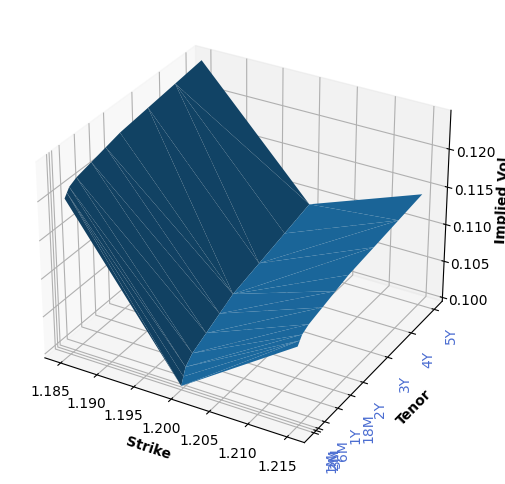

In [47]:
plot_FxVolSurface(result)

## TODO, Plans
- add barrier and touch options (single and double)
  - can be booked
  - cannot be priced, unless ANA-1351 "Add pricing for Barrier, Touch, etc... FxOption" is finished first
- getting quotes: use other data sources?! (for the moment local data are used)
- other price libaries (LUSID now, probably add QPS?!)
- different volsurface types?! (low priority)
- demonstrate how to handle errors (it is very practical: I lost quite some time debugging the notebook)
- CashFlows
- Greeks (add more sofisticated examples?!)
- Exposure (add more sofisticated examples?!)
- E V E N T S   ? !

## Comments from the presentation:

- add CTVM, SimpleStatic models
- use realistic today's values
- use constant volsurface (10%)
- add sections, comments (use the standard practice/format)
    - see https://wiki.finbourne.com/en/lusid/documentation/sample-notebooksGitContributing

In [48]:
1

1